<a href="https://colab.research.google.com/github/yemanzhongting/2019_learning/blob/master/%E8%B7%AF%E6%AE%B5%E5%8A%9F%E8%83%BD%E8%AF%86%E5%88%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/路段功能识别"

### 删除空间矩阵中没有边缘的

#### 开始50米路段缓冲区

In [ ]:
import pandas as pd
import numpy as np
data=pd.read_csv('/content/drive/MyDrive/路段功能识别/Buffer50.csv',header=0,index_col=0)

In [ ]:
data.shape

(2075, 2075)

In [ ]:
data=data[data.apply(np.sum,axis=1)!=0] #data是pandas的DataFrame类型数据
data=data.T
data=data[data.apply(np.sum,axis=1)!=0] #data是pandas的DataFrame类型数据
data=data.T
data.shape

(952, 952)

In [ ]:
data['row_sum']=data.apply(lambda x: x.sum(),axis=1)
data.head(1)

,2,5,8,10,11,12,21,37,43,44,...,17765,17766,17792,17793,17794,17795,17823,17838,17839,row_sum
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
sv=pd.read_csv('/content/drive/MyDrive/路段功能识别/空间链接表18k-街景-路段.csv')
sv.head(1)

,OBJECTID,Join_Count,TARGET_FID,descriptio,tags,lat_wgs,lon_wgs,pov_exp,heading,orgid,...,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,Shape_Length,Shape_Area
0,1,29.0,190.0,Ｇ１０７,GENERAL,30.612083,114.164546,2.0,107.0,10141003150599999000000.000000000000000,...,primary,工农路,,F,0.0,0.0,F,F,0.032367,1.837678e-07


In [ ]:
sv.shape

(18907, 41)

In [ ]:
sv.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'descriptio', 'tags', 'lat_wgs',
       'lon_wgs', 'pov_exp', 'heading', 'orgid', 'nid', 'scene', 'label',
       'multi_labe', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19',
       'F20', 'F21', 'BUFF_DIST', 'ORIG_FID', 'Shape_Leng', 'Join_Count_1',
       'TARGET_FID_1', 'osm_id', 'code', 'fclass', 'name', 'ref', 'oneway',
       'maxspeed', 'layer', 'bridge', 'tunnel', 'Shape_Length', 'Shape_Area'],
      dtype='object')

In [ ]:
### 选中50米缓冲区有空间关系的路段 OBJECTID->TARGET_FID

In [ ]:
pd.DataFrame({'index':data.index.values}).to_csv('1.csv')

In [ ]:
select=data.index.values.tolist()
sel_sv=sv[sv.TARGET_FID.isin(select)]
# sel_sv.head(1)

### 构select建路段与SV的关系

* 之前的select只是选择有空间相交
的，最多是2075，筛选900+，最后是选择有值的new_select 404

*  生成节点的emmbed



In [ ]:
osm_sv_scene={}
osm_sv_id={}
scene_list=[]

new_select=[]

for i in select:
  osm_sv_scene[i]=[]
  osm_sv_id[i]=[]
  for j in sel_sv[sel_sv['TARGET_FID']==i]['scene'].values.tolist():
    osm_sv_scene[i].append(j)

  for j in sel_sv[sel_sv['TARGET_FID']==i]['OBJECTID'].values.tolist(): 
    osm_sv_id[i].append(j)
  if len(osm_sv_id[i])!=0:
    new_select.append(i)

In [ ]:
print(len(new_select))
# new_select

404


#### 新筛选的SV,新的sel_sv

In [ ]:
select=data.index.values.tolist()
sel_sv=sv[sv.TARGET_FID.isin(new_select)]
sel_sv.head(1)

,OBJECTID,Join_Count,TARGET_FID,descriptio,tags,lat_wgs,lon_wgs,pov_exp,heading,orgid,...,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,Shape_Length,Shape_Area
1,2,54.0,863.0,三环线,GENERAL,30.460392,114.324191,2.0,271.0,10141050150399999000000.000000000000000,...,motorway,三环线,,F,0.0,1.0,T,F,0.066377,1.834866e-07


In [ ]:
sel_sv.shape

(2127, 41)

#### 生400+成嵌入

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

In [ ]:
osm_sv_scene={}
osm_sv_id={}
scene_list=[]
for i in new_select:
  osm_sv_scene[i]=[]
  osm_sv_id[i]=[]
  for j in sel_sv[sel_sv['TARGET_FID']==i]['scene'].values.tolist():
    osm_sv_scene[i].append(j)
  scene_list.append(' .'.join(osm_sv_scene[i]))

  for j in sel_sv[sel_sv['TARGET_FID']==i]['OBJECTID'].values.tolist(): 
    osm_sv_id[i].append(j)
len(scene_list)

404

In [ ]:
%time
embeddings = model.encode(scene_list)
# pd.DataFrame(osm_sv_embd).to_csv('/content/drive/MyDrive/路段功能识别/osm50embd.csv')

In [ ]:
osm_sv_embd={}
for index, value in enumerate(new_select):
	osm_sv_embd[value]=embeddings[index]

In [ ]:
pd.DataFrame(osm_sv_embd).to_csv('/content/drive/MyDrive/路段功能识别/osm50embd.csv')

#### 新筛选的OSM

In [ ]:
# osm=data[data.index.isin(new_select)]
# # osm=osm.T
# osm=osm[[str(x) for x in new_select]]
# osm.head(5)

In [ ]:
osm=osm[osm.apply(np.sum,axis=1)!=0] #data是pandas的DataFrame类型数据
osm.head()
# data=data.T
# data=data[data.apply(np.sum,axis=1)!=0] #data是pandas的DataFrame类型数据
# data=data.T
# data.shape

,2,5,10,11,37,43,44,45,49,50,...,17212,17436,17437,17606,17607,17724,17792,17793,17838,17839
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# osm.to_csv('osm.csv')

### 新建的三环路网5K开始计算


*   新导入,target_fid是街景的ID
*   新导入,join_fid是OSM重建的ID(0-5000+)
*   OSM FID是从0开始的 org_fid

In [ ]:
import pandas as pd
osm=pd.read_csv('/content/drive/MyDrive/路段功能识别/OSM_3Ring_FID_0514.csv')
osm.head(1)

,FID,OBJECTID,Join_Count,osm_id,BUFF_DIST,Shape_Leng
0,0,1,3,26130796,25.0,0.001527


In [ ]:
osm_fid=osm['FID'].values.tolist()

In [ ]:
sv=pd.read_csv('/content/drive/MyDrive/路段功能识别/武汉街景.csv')
sv['0517ID']=sv['nid'].apply(lambda x: x[0:23])
# df['age']=df['age'].apply(lambda x: x+3)
sv.head(1)

,FID,descriptio,tags,lat_wgs,lon_wgs,pov_exp,heading,orgid,nid,scene,...,F13,F14,F15,F16,F17,F18,F19,F20,F21,0517ID
0,0,Ｇ１０７,GENERAL,30.612083,114.164546,2.0,107.0,10141003150599999000000.000000000000000,10141003150629162530900_right_28.jpg,a road with cars driving on it ; a group of ca...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10141003150629162530900


In [ ]:
#不同值代表不同的用地类型
sv_osm=pd.read_csv('/content/drive/MyDrive/路段功能识别/空间链接表29k_街景_路段0514.csv')
# sv_osm=pd.read_csv('/content/drive/MyDrive/路段功能识别/空间链接表29k_街景_路段0517.csv')
print(sv_osm.columns)
sv_osm.head(1)

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'JOIN_FID', 'descriptio',
       'tags', 'lat_wgs', 'lon_wgs', 'pov_exp', 'heading', 'orgid', 'nid',
       'scene', 'label', 'multi_labe', 'BUFF_DIST', 'ORIG_FID', 'OBJECTID_1',
       'Join_Count_1', 'osm_id', 'Shape_Length', 'Shape_Area'],
      dtype='object')


,OBJECTID,Join_Count,TARGET_FID,JOIN_FID,descriptio,tags,lat_wgs,lon_wgs,pov_exp,heading,...,scene,label,multi_labe,BUFF_DIST,ORIG_FID,OBJECTID_1,Join_Count_1,osm_id,Shape_Length,Shape_Area
0,1,29,1,111,Ｇ１０７,GENERAL,30.612083,114.164546,2.0,107.0,...,a road with cars driving on it ; a group of ca...,9.0,[],30.0,0,1,1,58871382,0.001833,2.648248e-07


In [ ]:
# !cp -r /content/OsmRoadJoinLarge1_buffer_forgeoda_k5.gwt /content/drive/MyDrive/路段功能识别

In [ ]:
set(sv_osm['type'].values.tolist())

{' ', '0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', nan}

In [ ]:
sv_osm.shape
#平均5000+路段,每个路段有5个连接

(23368, 31)

In [ ]:
# JOIN_FID  为OSM的FID
# TARGET_FID 为SV的FID
# 来建立两者之间的联系
# 权重矩阵来建立OSM FID之间的联系
osm_fid[0]

0

In [ ]:
osm_sv_scene={}
osm_sv_id={}
osm_sv_imgpath={}

osm_sv_label={}
osm_sv_wuhan={}

for i in osm_fid:
  osm_sv_id[i]=sv_osm[sv_osm['JOIN_FID']==i]['TARGET_FID'].values.tolist()
  osm_sv_scene[i]=sv_osm[sv_osm['JOIN_FID']==i]['scene'].values.tolist()
  osm_sv_imgpath[i]=sv_osm[sv_osm['JOIN_FID']==i]['nid'].values.tolist()
  #来计算标签
  osm_sv_label[i]=sv_osm[sv_osm['JOIN_FID']==i]['multi_labe'].values.tolist()
  # osm_sv_wuhan[i]=sv_osm[sv_osm['JOIN_FID']==i]['type'].values.tolist()

In [ ]:
osm_sv_imgpath[50]

['10141019121207134605400_right_355.jpg',
 '10141019121207134554200_right_16.jpg',
 '10141019121207134551200_right_3.jpg',
 '10141019121207134558300_right_188.jpg',
 '10141019121207134608500_right_31.jpg']

#### 根据点生成街道SV数据集5000+,可以跳过,数据标注用

In [ ]:
!unzip /content/drive/MyDrive/街景数据.zip -d /content/streetview

In [ ]:
import os
image_files=[]
location_image={}
def file_name_listdir(file_dir):
  for file in os.listdir(file_dir):  # 不仅仅是文件，当前目录下的文件夹也会被认为遍历到
    if file.split('.')[-1]=='jpg':
      image_files.append(file)
      a=file[0:23]#.split('.')[0]
      if a in location_image:
        location_image[a].append(file)
      else:
        location_image[a]=[]
        location_image[a].append(file)
file_name_listdir('/content/streetview/')
print(len(image_files))

78984


In [ ]:
location_image['10141003150629162530900']

['10141003150629162530900_front_298.jpg',
 '10141003150629162530900_back_118.jpg',
 '10141003150629162530900_left_208.jpg',
 '10141003150629162530900_right_28.jpg']

In [ ]:
!mkdir /content/sv_labels
parent_dir='/content/sv_labels'
for i in osm_fid:
  id=str(i)
  mode = 0o666
  path = os.path.join(parent_dir,id)
  os.makedirs(path, mode)

In [ ]:
%time
import os
import shutil
for i in osm_fid:
  for j in osm_sv_imgpath[i]:
    # ['10141019131119135837000_right_59.jpg',
    # '10141019131119135831500_right_230.jpg',
    # '10141019131119135853800_right_44.jpg']
    tmp=j[0:23]
    for k in location_image[tmp]:
      # ['10141003150629162530900_front_298.jpg',
      # '10141003150629162530900_back_118.jpg',
      # '10141003150629162530900_left_208.jpg',
      # '10141003150629162530900_right_28.jpg']
      source=os.path.join('/content/streetview/',k)
      target=os.path.join(parent_dir,str(i))
      target=os.path.join(target,k)
      shutil.copy(source,target)

In [ ]:
# 如果为空的话,能不能利用均值填充,目前的0值填充

In [ ]:
!tar -zcvf /content/sv_labels.tar.gz /content/sv_labels

流式输出内容被截断，只能显示最后 5000 行内容。
/content/sv_labels/5118/10141003150522150322000_left_218.jpg
/content/sv_labels/5118/10141003150522150322000_right_38.jpg
/content/sv_labels/5118/10141003150522150427800_back_121.jpg
/content/sv_labels/5118/10141003150522150506300_right_220.jpg
/content/sv_labels/5118/10141003150522150134600_back_116.jpg
/content/sv_labels/5118/10141003150522150546800_left_253.jpg
/content/sv_labels/5118/10141003150522150506300_back_310.jpg
/content/sv_labels/5118/10141003150522150540000_back_314.jpg
/content/sv_labels/5118/10141003150522150506300_front_130.jpg
/content/sv_labels/5118/10141003150522150134600_front_296.jpg
/content/sv_labels/5118/10141003150522150203300_back_300.jpg
/content/sv_labels/5118/10141003150522150521400_front_142.jpg
/content/sv_labels/5118/10141003150522150546800_front_343.jpg
/content/sv_labels/5118/10141003150522150521400_left_52.jpg
/content/sv_labels/5118/10141003150522150546800_right_73.jpg
/content/sv_labels/5118/10141003150522150546800_back_1

In [ ]:
!cp -r /content/sv_labels.tar.gz /content/drive/MyDrive

In [ ]:
osm_sv_imgpath[0]

['10141019131119135837000_right_59.jpg',
 '10141019131119135831500_right_230.jpg',
 '10141019131119135853800_right_44.jpg']

#### 进行实验

In [ ]:
import torch
print(torch.__version__)  #注意是双下划线

1.11.0+cu113


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+${CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.11.0+.html
Looking in links: https://data.pyg.org/whl/torch-1.11.0+.html
  Using cached torch_sparse-0.6.13.tar.gz (48 kB)
  Created wheel for torch-sparse: filename=torch_sparse-0.6.13-cp37-cp37m-linux_x86_64.whl size=501789 sha256=c2b5a6bf7e4a544c3ca596a777de99831b07640e89bcc3ac1899019382e37abb
  Stored in directory: /root/.cache/pip/wheels/e0/01/be/6b2966e0ff20bb023ae35e5d17903e6e5b4df46dd5892f6be6
Successfully built torch-sparse


#### 先构建边 

In [ ]:
with open('/content/drive/MyDrive/路段功能识别/OsmRoadJoinLarge1_buffer_forgeoda_k5.gwt','r+') as f:
  edges=f.readlines()

In [ ]:
# with open('/content/drive/MyDrive/路段功能识别/OsmRoadJoinLarge1_buffer_forgeoda_k5.gwt','r+') as f:
#   edges=f.readlines()

In [ ]:
edge_index=[]
for edge in edges[1:]:
  edge_index.append(list(map(int,edge.split(' ')[0:2])))
edge_index = torch.tensor(edge_index, dtype=torch.long) 
len(edge_index)

27290

#### 再构建X

In [ ]:
# !pip install -U sentence-transformers
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

In [ ]:
scene_list=[]
for fid in osm_fid:
  if len(osm_sv_scene[fid])>0:
    scene_list.append('.'.join(osm_sv_scene[fid]))
  else:
    scene_list.append('')

In [ ]:
%time
# embeddings = model.encode(scene_list)

print(pd.read_csv('/content/drive/MyDrive/路段功能识别/osmembd0516.csv').values.shape)
embeddings=pd.read_csv('/content/drive/MyDrive/路段功能识别/osmembd0516.csv').values[:,1:].T
embeddings.shape

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs
(768, 5459)


(5458, 768)

In [ ]:
osm_sv_embd={}
for index, value in enumerate(osm_fid):
	osm_sv_embd[value]=embeddings[index]
# pd.DataFrame(osm_sv_embd).to_csv('/content/drive/MyDrive/路段功能识别/osmembd0516.csv')

#### 最后构建y以及test_mask

In [ ]:
labels=[101,201,202,301,402,501,502,503,504,505]
slabels=["['101']","['201']","['202']","['301']","['402']","['501']","['502']","['503']","['504']","['505']"]
types_label=['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
#{' ', '0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', nan}

In [ ]:
#计算出标签以及标签个数 old
osm_fid_label={}
for fid in osm_fid:
  tmp=osm_sv_label[fid]
  max_label=max(tmp,key=tmp.count)
  max_label_num=tmp.count(max(tmp,key=tmp.count))
  if max_label in slabels:
    res_label=slabels.index(max_label)
  else:
    res_label=-1
  osm_fid_label[fid]=[res_label,max_label_num]

In [ ]:
#提取大于2数量的值
label_mask=[]
label_y=[]
for fid in osm_fid:
  if osm_fid_label[fid][1]>2 and osm_fid_label[fid][0]!=-1:
    label_y.append(osm_fid_label[fid][0])
    label_mask.append(True)
  else:
    label_y.append(-1)
    label_mask.append(False)

In [ ]:
from collections import Counter
result = Counter(label_y)
result

Counter({-1: 4930,
         0: 320,
         1: 15,
         2: 29,
         3: 37,
         4: 6,
         5: 6,
         6: 65,
         7: 12,
         8: 28,
         9: 10})

In [ ]:
#提取大于2数量的值
label_mask=[]
label_y=[]
balanced_label=0
for fid in osm_fid:
  if osm_fid_label[fid][0]==0:
    balanced_label=balanced_label+1
  if osm_fid_label[fid][1]>2 and osm_fid_label[fid][0]!=-1:
    if balanced_label>200 and osm_fid_label[fid][0]==0:
      label_y.append(-1)
      label_mask.append(False)
    else:
      label_y.append(osm_fid_label[fid][0])
      label_mask.append(True) 
  else:
    label_y.append(-1)
    label_mask.append(False)
from collections import Counter
result = Counter(label_y)
result

Counter({-1: 5163,
         0: 87,
         1: 15,
         2: 29,
         3: 37,
         4: 6,
         5: 6,
         6: 65,
         7: 12,
         8: 28,
         9: 10})

In [ ]:
pd.DataFrame({'Origin':np.array(label_y)}).to_csv('Origin.csv')

In [ ]:
# data.test_mask

#### 导入可视化库

In [ ]:
# Install required packages.
import os
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

#### 开始尝试训练

In [ ]:
embeddings.shape

(5458, 768)

In [ ]:
import torch
from torch_geometric.data import Data
import numpy as np
# edge_index = edge_index
x = torch.tensor(embeddings, dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(),
y=torch.from_numpy(np.array(label_y)),
train_mask=torch.from_numpy(np.array(label_mask)),
test_mask=torch.from_numpy(np.array(label_mask)))

In [ ]:
# import numpy as np
# array = np.random.rand(len(data.train_mask),1)
# index_bool = data.train_mask
# result = array[index_bool]
# len(result)

In [ ]:
from torch_geometric.nn import GCNConv
import torch
from torch.nn import Linear
import torch.nn.functional as F
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(768, hidden_channels)
        self.conv2 = GCNConv(hidden_channels,10)#dataset.num_classes

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
model = GCN(hidden_channels=32)
print(model)

GCN(
  (conv1): GCNConv(768, 32)
  (conv2): GCNConv(32, 10)
)


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# data =  data.to(device)
# model = model().to(device) 

In [ ]:
# model = GCN(hidden_channels=32)
# model.eval()

# out = model(data.x, data.edge_index)
# visualize(out, color=data.y)

In [ ]:
data.y[data.train_mask]

tensor([6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 9, 8, 3, 0, 8, 6, 1, 9, 6, 0,
        0, 0, 3, 1, 6, 6, 6, 0, 1, 0, 0, 0, 0, 7, 7, 7, 6, 6, 6, 0, 6, 6, 3, 0,
        0, 0, 1, 0, 2, 1, 0, 6, 6, 3, 8, 0, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 9,
        0, 0, 6, 5, 6, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 9, 6, 6, 6, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 0, 0, 2, 6, 0, 0, 5, 0, 6, 6, 6,
        0, 6, 5, 9, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 0, 8, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 6, 6, 1, 2, 6, 3, 4, 4, 4, 2, 2, 2, 7, 7, 1, 2, 2,
        2, 2, 1, 2, 2, 8, 7, 2, 2, 2, 1, 2, 8, 9, 8, 3, 3, 3, 8, 7, 2, 8, 6, 6,
        6, 4, 8, 6, 6, 6, 3, 8, 6, 8, 6, 6, 2, 3, 2, 6, 6, 6, 4, 6, 6, 2, 6, 3,
        3, 2, 6, 6, 9, 6, 1, 1, 1, 3, 8, 9, 1, 2, 8, 8, 2, 6, 6, 6, 6, 8, 8, 8,
        9, 3, 1, 2, 3, 5, 9, 3, 6, 6, 6, 8, 8, 6, 6, 8, 5, 1, 3, 3, 3, 4, 3, 3,
        8, 8, 8, 3, 6, 7, 7, 7, 7, 8, 5, 3, 6, 3, 3, 6, 7, 8, 8, 6, 6, 6, 3, 3,
        3, 3, 8, 3, 3, 6, 6])

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 2.6071
Epoch: 002, Loss: 3.1496
Epoch: 003, Loss: 3.0219
Epoch: 004, Loss: 2.4411
Epoch: 005, Loss: 2.2446
Epoch: 006, Loss: 2.0581
Epoch: 007, Loss: 1.9289
Epoch: 008, Loss: 1.9253
Epoch: 009, Loss: 1.9204
Epoch: 010, Loss: 1.9309
Epoch: 011, Loss: 1.8949
Epoch: 012, Loss: 1.8473
Epoch: 013, Loss: 1.8294
Epoch: 014, Loss: 1.7931
Epoch: 015, Loss: 1.8031
Epoch: 016, Loss: 1.8491
Epoch: 017, Loss: 1.7925
Epoch: 018, Loss: 1.7568
Epoch: 019, Loss: 1.7577
Epoch: 020, Loss: 1.7584
Epoch: 021, Loss: 1.7198
Epoch: 022, Loss: 1.7546
Epoch: 023, Loss: 1.6988
Epoch: 024, Loss: 1.6773
Epoch: 025, Loss: 1.6562
Epoch: 026, Loss: 1.6495
Epoch: 027, Loss: 1.6339
Epoch: 028, Loss: 1.6607
Epoch: 029, Loss: 1.6326
Epoch: 030, Loss: 1.6803
Epoch: 031, Loss: 1.6599
Epoch: 032, Loss: 1.6283
Epoch: 033, Loss: 1.6332
Epoch: 034, Loss: 1.6047
Epoch: 035, Loss: 1.6133
Epoch: 036, Loss: 1.6194
Epoch: 037, Loss: 1.5879
Epoch: 038, Loss: 1.5573
Epoch: 039, Loss: 1.5667
Epoch: 040, Loss: 1.5662


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5627


#### 获取计算好的资源

In [ ]:
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.

In [ ]:
len(pred)

5458

In [ ]:
pd.DataFrame({'Type':pred.numpy()}).to_csv('pred.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


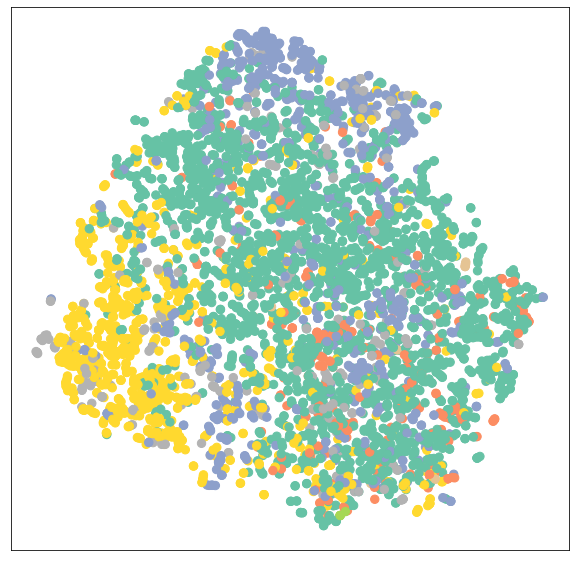

In [ ]:
model = GCN(hidden_channels=32)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=pred)

### 其他的数据

#### 构建数据集

In [ ]:
import torch
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

# custom dataset
class KarateDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(KarateDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = G.number_of_nodes()
        
        # embedding 
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        
        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(list(G.nodes())), 
                                                            pd.Series(labels),
                                                            test_size=0.30, 
                                                            random_state=42)
        
        n_nodes = G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = KarateDataset()
data = dataset[0]

#### 空手道俱乐部

In [ ]:
import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# load graph from networkx library
G = nx.karate_club_graph()

# retrieve the labels for each node
labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# create edge index from 
adj = nx.to_scipy_sparse_matrix(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

# using degree as embedding
embeddings = np.array(list(dict(G.degree()).values()))

# normalizing degree values
scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))

In [ ]:
data.test_mask

In [ ]:
data

In [ ]:
import numpy as np

array = np.random.rand(len(data.y),1)
index_bool = data.train_mask#.numpy()

In [ ]:
array.shape

In [ ]:
type(index_bool)

In [ ]:
result = Counter(array[index_bool])
result

In [ ]:
result = array[index_bool]
len(result)

In [ ]:
tensor2array = data.y.numpy()
print(tensor2array)

In [ ]:
pd.DataFrame({'Y':tensor2array}).to_csv('1.csv')

In [ ]:
# import os
# with open('OsmRoadJoinLarge1_buffer_forgeoda.gal')

### 数据加载模板

In [ ]:
###https://github.com/benedekrozemberczki/karateclub

In [ ]:
af=pd.read_csv('/content/师弟师妹标注.txt')
types=set(af['type'].values.tolist())
for i in types:
  print(i)
  print(af[af['type']==i].shape)

9
(752, 5)
1
(1505, 5)
8
(9, 5)
0
(1, 5)
 
(112, 5)
2
(241, 5)
5
(95, 5)
3
(194, 5)
4
(152, 5)
7
(19, 5)
10
(289, 5)
6
(935, 5)
